# Time Series Forecasting Models: Stock prices data

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from datetime import datetime
import seaborn as sns

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data

In [2]:
## Historical BSE stock prices from 2017-06-29 to 2018-06-29, (Yahoo! Finance)
data = pd.read_csv("^BSESN.csv")
data['Date'] = data['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-29,30910.970703,31097.919922,30794.609375,30857.519531,30857.519531,12300
1,2017-06-30,30824.970703,30965.449219,30680.660156,30921.609375,30921.609375,9200
2,2017-07-03,31156.039063,31258.330078,31017.109375,31221.619141,31221.619141,8100
3,2017-07-04,31331.210938,31353.460938,31166.369141,31209.789063,31209.789063,8700
4,2017-07-05,31272.720703,31284.640625,31177.779297,31245.560547,31245.560547,6500


In [3]:
data = data.set_index("Date")


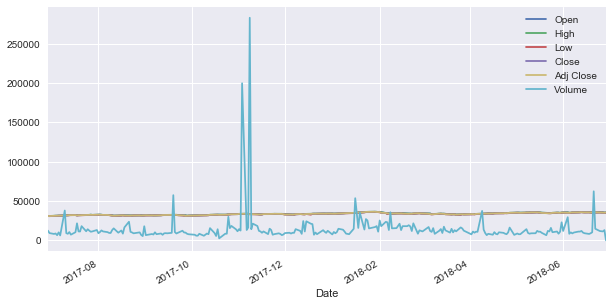

In [4]:
data.plot(figsize = (10,5))
plt.show()

In [5]:
# Closing prices time series
TS = data["Close"]

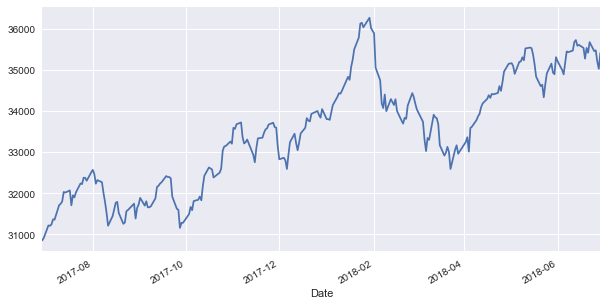

pandas.core.series.Series

In [6]:
TS.plot(figsize = (10,5))
plt.show()
type(TS)

### Stationarity

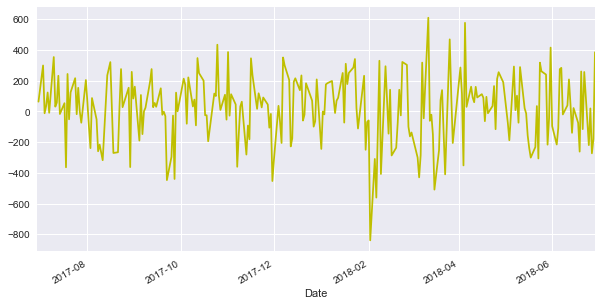

In [7]:
diff = TS - TS.shift(1)
diff.plot(figsize = (10,5), c = 'y')
plt.show()

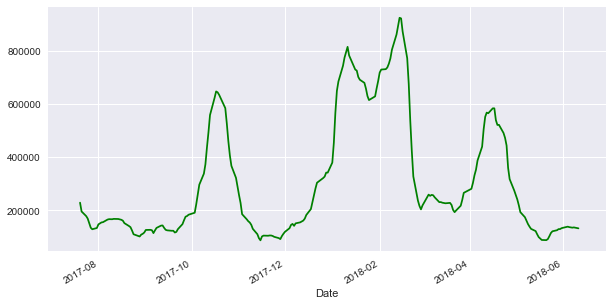

In [8]:
variance = pd.Series.rolling(TS, window = 30, center = True).var()
variance.plot(figsize = (10,5), c = 'g')
plt.show()

In [9]:
data_log = TS.apply(lambda x: np.log(x))
## to even out fluctuations

## Autocorrelation

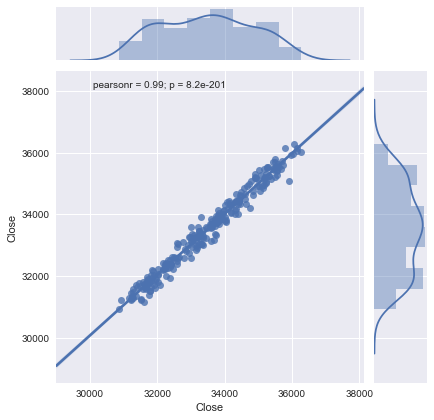

In [10]:
sns.jointplot(TS.shift(1), TS, kind = 'reg')
plt.show()

In [11]:
df = pd.concat([TS.shift(1), TS], axis = 1)
df.columns = ['t-1', 't']
result = df.corr()
print(result)

          t-1         t
t-1  1.000000  0.987454
t    0.987454  1.000000


### Autocorrelation Plots

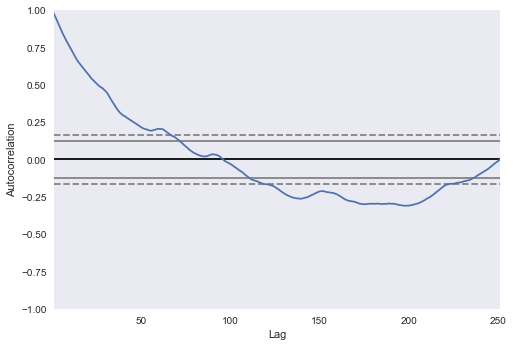

In [12]:
#Using Pandas
pd.plotting.autocorrelation_plot(TS)
plt.show()

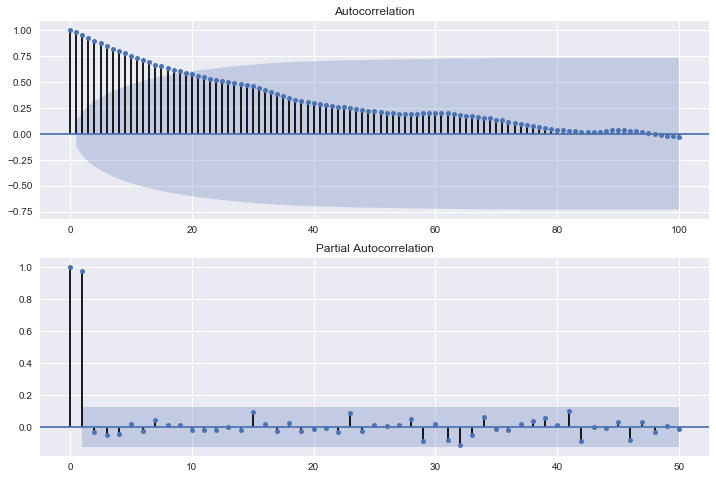

In [13]:
#Using Statsmodels library
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(TS, lags = 100, ax = ax1) #autocorrelation function
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(TS, lags = 50, ax = ax2) #partial autocorrelation function


PACF function indicates lag(0) and lag(1) partial autocorrelations are high. Therfore use autoregression with lag = 2.

# MODELS

# AutoRegression model

In [14]:
# split dataset for training and testing
from datetime import timedelta
test_size = 100
train = TS[0:len(TS)-test_size]
test = TS[-test_size:]

In [15]:
# Train autoregressor
model_ar = sm.tsa.ARMA(TS, order = (2,0)).fit()

In [16]:
model_ar.params

const          33344.885736
ar.L1.Close        1.112526
ar.L2.Close       -0.121794
dtype: float64

### Predictions

In [17]:
start = TS.index[len(TS)-100]
end = TS.index[-1]
predictions = model_ar.predict(start, end , dynamic = False)
model_ar.plot_predict(start, end, dynamic = False)
type(predictions)

pandas.core.series.Series

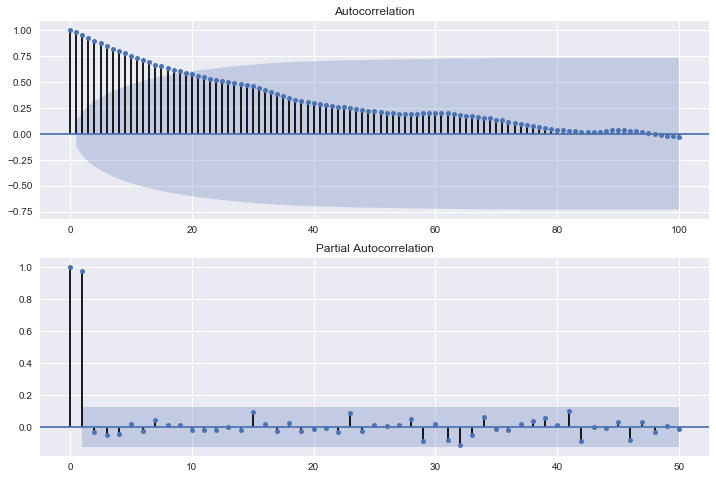

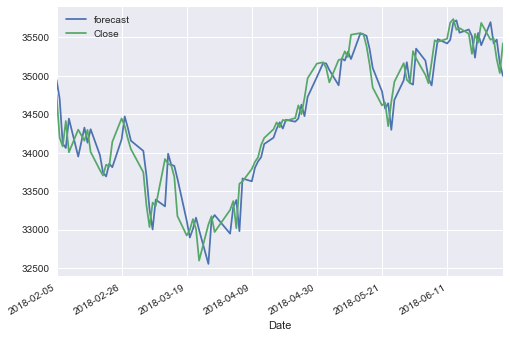

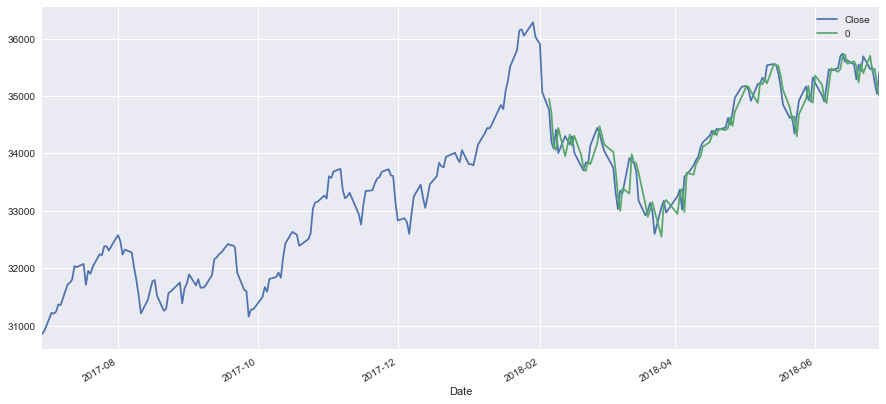

In [18]:
prediction_df = pd.concat([TS, predictions], axis = 1)
prediction_df.plot(figsize = (15,7))
plt.show()

### Out-of-sample forecasting

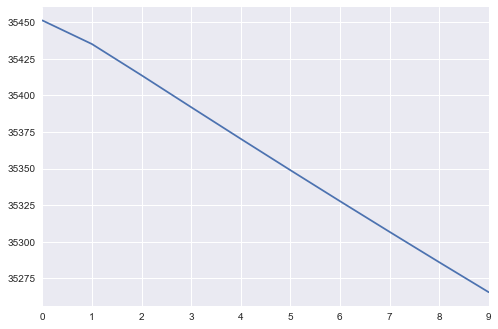

In [19]:
forecast = model_ar.forecast(steps = 10)
pd.Series(forecast[0]).plot()
plt.show()